# Task 1: Tabular Q-Learning Update

## Q-Table Initialization

In [16]:
import numpy as np

def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))

q_table = init_q_table(5, 4)
print("Q-table shape:", q_table.shape)
print("\nInitial Q-table:\n\n", q_table)


Q-table shape: (5, 4)

Initial Q-table:

 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## Q-Table Update Function

In [17]:
def q_update(Q, s, a, r, s_next, α, γ):
    max_next_q = np.max(Q[s_next])
    Q[s,a] += α * (r + γ * max_next_q - Q[s,a])
    return Q


Q = np.zeros((3, 2))
Q = q_update(Q, 0, 1, 5, 1, 0.1, 0.9)
print("Updated Q-table:\n\n", Q)



Updated Q-table:

 [[0.  0.5]
 [0.  0. ]
 [0.  0. ]]


# Task 2: ε-Greedy Policy on GridWorld

## GridWorld Definition

In [ ]:
class GridWorld:
    def __init__(self):
        self.size = 4
        self.start = (0, 0)
        self.goal = (3, 3)
        self.state = self.start
        self.actions = ['up', 'down', 'left', 'right']
        
    def reset(self):
        self.state = self.start
        return self.get_state_index()
    
    def get_state_index(self):
        return self.state[0] * self.size + self.state[1]
    
    def step(self, action):
        x, y = self.state
        if action == 'up': x = max(0, x-1)
        elif action == 'down': x = min(3, x+1)
        elif action == 'left': y = max(0, y-1)
        elif action == 'right': y = min(3, y+1)
        
        self.state = (x, y)
        done = (self.state == self.goal)
        reward = 10 if done else -1
        return self.get_state_index(), reward, done


## ε-Greedy Action Selection

In [ ]:
def select_action(Q, state, ε):
    if np.random.random() < ε:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

## Training and Evaluation

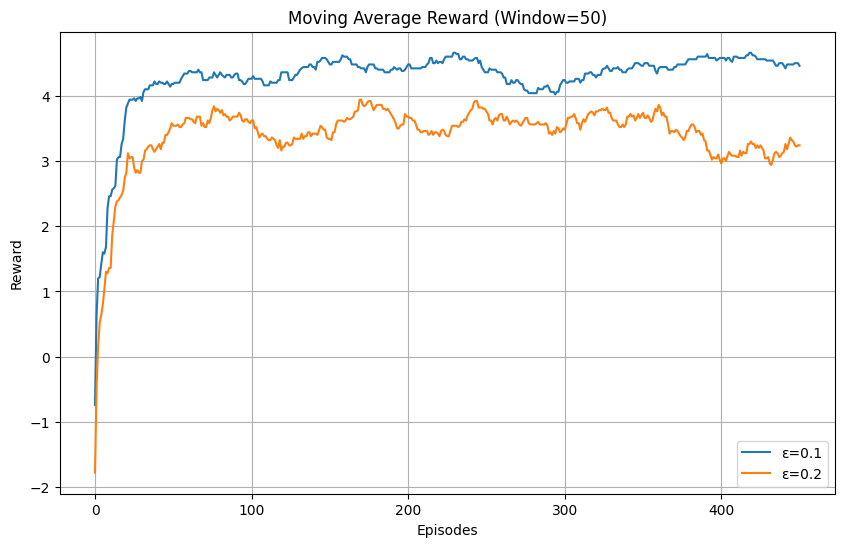

In [20]:
import matplotlib.pyplot as plt

def train_gridworld(ε, num_episodes=500):
    env = GridWorld()
    n_states = 16
    n_actions = 4
    Q = init_q_table(n_states, n_actions)
    rewards = []
    
    for _ in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = select_action(Q, state, ε)
            next_state, reward, done = env.step(env.actions[action])
            Q = q_update(Q, state, action, reward, next_state, 0.1, 0.99)
            state = next_state
            total_reward += reward
            
        rewards.append(total_reward)
    
    return np.convolve(rewards, np.ones(50)/50, mode='valid')

plt.figure(figsize=(10,6))
for ε in [0.1, 0.2]:
    rewards = train_gridworld(ε)
    plt.plot(rewards, label=f'ε={ε}')
plt.title('Moving Average Reward (Window=50)')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()



## Interpretation:

##### The ε=0.2 curve shows slower convergence due to higher exploration, while ε=0.1 converges faster. Higher epsilon values means more exploration, which can lead to better long-term performance but require more episodes.

# Task 3: Experience Replay Buffer

## Replay Buffer Implementation

In [21]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.bool_)
        )

## Buffer ka demo:

In [22]:
buffer = ReplayBuffer(100)
for _ in range(100):
    buffer.push(
        np.random.randint(16),
        np.random.randint(4),
        np.random.rand(),
        np.random.randint(16),
        np.random.rand() > 0.5
    )

batch = buffer.sample(32)
print("Shapes:", [x.shape for x in batch])
print("Data types:", [x.dtype for x in batch])

Shapes: [(32,), (32,), (32,), (32,), (32,)]
Data types: [dtype('int64'), dtype('int64'), dtype('float32'), dtype('int64'), dtype('bool')]


# Task 4: DQN Networks

## DQN Network Architectures

In [28]:
import torch
import torch.nn as nn

class DQNPolicy(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        return self.net(x)
    
class DQNTarget(DQNPolicy):
    pass  # Same architecture as DQNpolicy

## Target Network Update

In [24]:
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Test networks
policy_net = DQNPolicy(4, 2)
target_net = DQNTarget(4, 2)
update_target(policy_net, target_net)

# Task 5: DQN Training on CartPole

## Setup

In [ ]:
import gymnasium as gym
import torch.optim as optim

env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Hyperparameters
# started with a smaller batch size for quick checking
N = 1000
M = 0.001
X = 10
batch_size = 64
gamma = 0.99

# Initializing components:
policy_net = DQNPolicy(state_dim, action_dim)
target_net = DQNTarget(state_dim, action_dim)
update_target(policy_net, target_net)
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
buffer = ReplayBuffer(10000)
loss_fn = nn.MSELoss()
episode_rewards = []

## Training loop

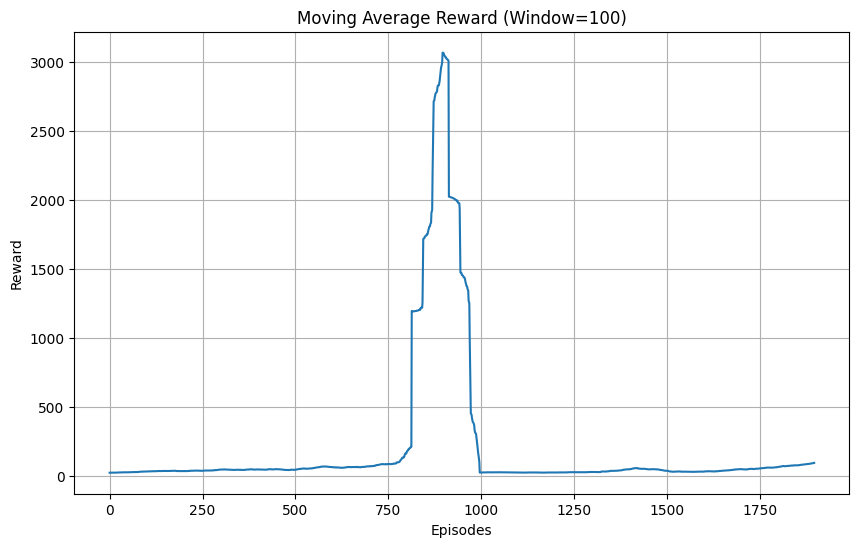

Success rate: 4.36%


In [ ]:
for episode in range(N):
    state, _ = env.reset()
    ε = max(0.01, 1 - episode * M)
    total_reward = 0
    done = False
    
    while not done:
        # Epsilon-greedy:
        if np.random.random() < ε:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state)
                action = policy_net(state_tensor).argmax().item()
                
        # Environment step
        next_state, reward, done, _, _ = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        # Took care of edge case, checking whether Buffer Length is bigger than Batch Size
        if len(buffer.buffer) >= batch_size:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            
            # Convert to tensors
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.FloatTensor(next_states)
            dones = torch.BoolTensor(dones)
            
            with torch.no_grad():
                target_q = rewards + gamma * target_net(next_states).max(1)[0] * ~dones
            
            current_q = policy_net(states).gather(1, actions.unsqueeze(1))
            
            # Update network
            loss = loss_fn(current_q, target_q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    if episode % X == 0:
        update_target(policy_net, target_net)
        
    episode_rewards.append(total_reward)
    

plt.figure(figsize=(10,6))
window_size = N//10
moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title(f'Moving Average Reward (Window={window_size})')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.grid(True)
plt.show()


success_rate = np.mean(np.array(episode_rewards) >= 195) * 100
print(f"Success rate: {success_rate:.2f}%")
